# Monte Carlo

We want to calculate:
$$p = \int_2^{\infty} \frac{1}{\pi (1 + x^2)} dx = 0.15$$

Using Monte Carlo. We use a fixed number of points across all experiments:

In [96]:
N = 10000

Let us try some some estimators:

1. $$\hat{p}_1 = \frac{1}{n} \sum_i^n I(X_i > 2),\ X \sim \textrm{Cauchy}$$

In [159]:
from numpy.random import standard_cauchy

# Compute mean
points = standard_cauchy(size=N)
mean = (points > 2).sum() / N
print(f"Mean: {mean}")

# Compute variance
variance = ((points - mean) ** 2).sum() / N
print(f"Variance: {variance}")

Mean: 0.1465
Variance: 2059.5451384825983


Running the above section multiple times, you will notice that the variance varies over a very large range. This suggests the unstable variance of the Cauchy distribution.

2. $$ \hat{p}_2 = \frac{1}{2n} \sum_i^n I(\vert X_i \vert > 2),\ X \sim \textrm{Cauchy} $$

This estimator estimates the following:
$$ p(x) = \frac{1}{2} \int_{-\infty}^{-2} \frac{1}{\pi (1 + x^2)} dx + \frac{1}{2} \int_{2}^{\infty} \frac{1}{\pi (1 + x^2)} dx $$


In [167]:
from numpy import abs

# Compute mean
points = standard_cauchy(size=N)
mean = (abs(points) > 2).sum() / N / 2.
print(f"Mean: {mean}")

# Compute variance
variance = ((points - mean) ** 2).sum() / N
print(f"Variance: {variance}")

Mean: 0.14735
Variance: 266063.386701837


Similar to estimator $\hat{p}_1$, this estimator has very unstable variance.

3. $$ \hat{p}_3 = \frac{1}{2} - \frac{1}{n} \sum_i^n \frac{2}{\pi (1 + X_i)^2},\ X \sim \mathcal{U}[0., 2.] $$

In [228]:
from numpy import pi
from numpy.random import uniform

# Compute mean
points = uniform(low=0., high=2., size=N)
mean = 0.5 - (2. / (pi * (1. + points ** 2))).sum() / N
print(f"Mean: {mean}")

# Compute variance
variance = ((points - mean) ** 2).sum() / N
print(f"Variance: {variance}")

Mean: 0.14512611871672004
Variance: 1.0506108422727394


**INCOMPLETE, WRONG MEAN**

4. $$ \hat{p}_4 = \frac{1}{2n} \sum_i^n \frac{X_i^{-2}}{\pi (1 + X_i^{-2})},\ X \sim \mathcal{U}[0., 0.5] $$

In [250]:
from numpy import power

# Compute mean
points = uniform(low=0., high=0.5, size=N)
points_inv_sqr = pow(points, -2.)
mean = (points_inv_sqr / pi / (1 + points_inv_sqr)).sum() / N / 2.
print(f"Mean: {mean}")

# Compute variance
variance = ((points - mean) ** 2).sum() / N
print(f"Variance: {variance}")

Mean: 0.14763444120002142
Variance: 0.03104030658409656


## Normal-Cauchy Bayes Estimator

We wish to use Monte Carlo to estimate the integral of:

$$ \delta(x) = \frac{\int_{-\infty}^{\infty} \frac{\theta}{1 + \theta^2} \exp \left( -\frac{(x - \theta)^2}{2} \right) d\theta}{\int_{-\infty}^{\infty} \frac{1}{1 + \theta^2} \exp \left( -\frac{(x - \theta)^2}{2} \right) d\theta} $$



In [252]:
def normal_cauchy_bayes_estimator (sample_count):
    print("hi")

normal_cauchy_bayes_estimator(10)

hi


## Proof of Something
We want to show that
$$ \mathbb{E}[e^{-X^2}] = \frac{1}{\sqrt{2\sigma^2 + 1}},\ X \sim \mathcal{N}(0., \sigma^2) $$

Using the Law of the Unconcious Statistician, we have:
$$ \mathbb{E}[e^{-X^2}] = \int_{-\infty}^{\infty} e^{-x^2} \mathcal{N}(0., \sigma^2) dx = \int_{-\infty}^{\infty} \exp(-x^2) \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left({\frac{-x^2}{2\sigma^2}} \right) dx $$

$$ = \int_{-\infty}^{\infty} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( \frac{-x^2 (2 \sigma^2 + 1)}{2\sigma^2} \right) = \int_{-\infty}^{\infty} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( \frac{-x^2}{2\sigma^2} \right) \exp \left( \frac{(2 \sigma^2 + 1)}{2\sigma^2} \right) $$

## Particle Filtering


## n-D Markov Chain Monte Carlo
Given some *unknown* $n$-dimensional multivariate density, we want to estimate it using Markov Chain Monte Carlo. We structure the task as an optimization on some `target` density, starting the Markov Chain at some `initial` value $x_0 \in \mathbb{R}^n$, and using an $n$-D multivariate Gaussian proposal density with variance `variance`, centered on the current state of the chain:

In [11]:
from numpy import zeros
from numpy.random import uniform, randn

def estimate_density_mcmc (target_density, initial_value, proposal_variance, iterations=5000):
    # Pre-allocate the markov chain
    markov_chain = zeros((iterations, *initial_value.shape))
    # Add initial value to the chain
    markov_chain[0] = initial_value
    accepted_count = 0.
    # Build chain
    for i in range(iterations - 1):
        # Get a point from the proposal density
        current_point = markov_chain[i]
        proposal_point = current_point + randn(*current_point.shape) * proposal_variance
        # Compute the acceptance ratio
        current_value, proposal_value = target_density(current_point), target_density(proposal_point)
        acceptance_ratio = min(1., proposal_value / current_value)
        # Accept or reject with Metropolis-Hastings heuristic
        accept = uniform() < acceptance_ratio
        accepted_count += accept
        markov_chain[i + 1] = proposal_point if accept else current_point
    # Return the chain and the acceptance rate
    acceptance_rate = accepted_count / iterations
    return markov_chain, acceptance_rate

First, let's test on a univariate proposal density:

Acceptance rate: 0.1484


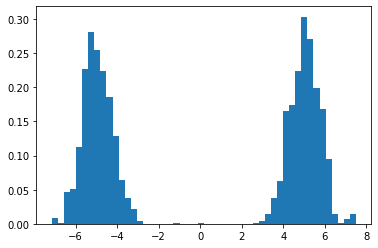

In [298]:
%matplotlib inline

from matplotlib import pyplot as plt
from numpy import exp

# 1D target density from example code, simple bi-modal Gaussian
def target_1d (x):
    return exp(-(x-5) ** 2) + exp(-(x+5) ** 2)

# Estimate and plot
estimated_density_1d, acceptance_rate_1d = estimate_density_mcmc(target_1d, zeros(1,), 10)
print(f"Acceptance rate: {acceptance_rate_1d}")
plt.hist(estimated_density_1d, 50, density=True)
plt.show()

Now let us test it on some random multi-variate proposal density. First, we estimate the density using MCMC, then to sample from it, we build a Gaussian Kernel Density Estimator. We then draw samples, from the KDE and the target density, and compute the KL-divergence between them.

In [317]:
from numpy import append, array, meshgrid, linspace
from scipy.stats import entropy, gaussian_kde, multivariate_normal

# 2D Gaussian centered on zero, with covariance
def target_2d (x):
    MEAN = zeros(2,)
    COVARIANCE = array([
        [1., .5],
        [.5, 1.]
    ])
    return multivariate_normal.pdf(x, mean=MEAN, cov=COVARIANCE)

# Estimate using Gaussian proposal density with variance 5.
initial_value = array([-4., 4.])
estimated_density_2d, acceptance_rate_2d = estimate_density_mcmc(target_2d, initial_value, 3., iterations=10000)

# Build a density from the markov chain using a Gaussian KDE
estimator_2d = gaussian_kde(estimated_density_2d.T)

# Create a sample grid so we can sample from both densities
GRID_EXTENT = 100 # Grid will have n^2 points, with n points on each axis
points_X, points_Y = meshgrid(linspace(-2., 2., GRID_EXTENT), linspace(-2., 2., GRID_EXTENT))
sample_grid = append(points_X.reshape(-1,1), points_Y.reshape(-1,1), axis=1)

# Now we sample from both the true target and estimated densities
true_samples = target_2d(sample_grid)
estimator_samples = estimator_2d(sample_grid.T) # This wants [d, N] so we transpose

# Compute KL-div
kl_divergence  = entropy(true_samples, estimator_samples)
print(f"KL divergence: {kl_divergence}")

KL divergence: 0.01111967461232985


## Monte Carlo Optimization
We can use MCMC to perform global optimization within some hypercube in a given parameter space. It is a very similar to creating a markov chain for estimating a target density. Let us define an MCMC optimizer which optimizes a given objective `objective` by searching through a hypercube $[a, b]^n$ in some parameter space.

In [89]:
from numpy import argmin, clip, exp
from numpy.random import normal

def minimize_mcmc (objective, initial_value, lower_bound, upper_bound, proposal_variance, iterations=5000):
    # Modify the objective to be strictly positive
    old_objective = objective
    objective = lambda x: exp(old_objective(x))
    # Pre-allocate the markov chain for both the samples and their objective values
    points = zeros((iterations, *initial_value.shape))
    points[0] = initial_value
    initial_response = objective(initial_value)
    responses = zeros((iterations, *initial_response.shape))   
    responses[0] = initial_response 
    # Build chain
    accepted_count = 0.
    for i in range(iterations - 1):
        # Get a point from the proposal density
        current_point = points[i]
        proposal_point = normal(loc=current_point, scale=proposal_variance, size=current_point.shape)
        proposal_point = clip(proposal_point, lower_bound, upper_bound)
        # Get the current objective value
        current_response = responses[i]
        proposal_response = objective(proposal_point)
        # Accept or reject with Metropolis-Hastings heuristic
        acceptance_ratio = min(1., current_response / proposal_response)
        accept = uniform() < acceptance_ratio
        accepted_count += accept
        points[i + 1] = proposal_point if accept else current_point
        responses[i + 1] = proposal_response if accept else current_response
    # Return the maximizer and the acceptance rate
    minimizer = points[argmin(responses)]
    acceptance_rate = accepted_count / iterations
    return minimizer, acceptance_rate

Now we test it on the following objective function:
$$ J(x, y) = (x \sin(20y) + y \sin(20x))^2 \cdot \cosh(x \sin(10x)) + (x \cos(10y) - y \sin (10x))^2 \cdot \cosh (y \cos (20y)) $$

In [107]:
from numpy import array, cos, cosh, sin

# Define J(\theta) from above
def objective (theta):
    x, y = theta
    return (x * sin(20 * y) + y * sin(20 * x)) ** 2 * cosh(x * sin(10 * x)) + (x * cos(10 * y) - y * sin(10 * x)) ** 2 * cosh(y * cos(20 * y))

# Optimize using MCMC
INITIAL_VALUE = array([0.5, 0.5])
LOWER_BOUND = array([-1., -1.]) # Per-parameter bound
UPPER_BOUND = array([1., 1.]) # Per-parameter bound
optimum, acceptance_rate = minimize_mcmc(objective, INITIAL_VALUE, LOWER_BOUND, UPPER_BOUND, 1., iterations=5000)
print(f"Found minimum at {optimum} with acceptance rate {acceptance_rate}")

Found minimum at [8.99662238e-05 1.00000000e+00] with acceptance rate 0.518
